
# Tutorial on learning to accumulate evidence with e-prop

Training a classification model using supervised e-prop plasticity to accumulate evidence.

## Description

This script demonstrates supervised learning of a classification task with the eligibility propagation (e-prop)
plasticity mechanism by Bellec et al. [1]_.

This type of learning is demonstrated at the proof-of-concept task in [1]_. We based this script on their
TensorFlow script given in [2]_.

The task, a so-called evidence accumulation task, is inspired by behavioral tasks, where a lab animal (e.g., a
mouse) runs along a track, gets cues on the left and right, and has to decide at the end of the track between
taking a left and a right turn of which one is correct. After a number of iterations, the animal is able to
infer the underlying rationale of the task. Here, the solution is to turn to the side in which more cues were
presented.

<img src="file://../../../../pynest/examples/eprop_plasticity/eprop_supervised_classification_schematic_evidence-accumulation.png" width="70 %" alt="See Figure 1 below." align="center">

Learning in the neural network model is achieved by optimizing the connection weights with e-prop plasticity.
This plasticity rule requires a specific network architecture depicted in Figure 1. The neural network model
consists of a recurrent network that receives input from Poisson generators and projects onto two readout
neurons - one for the left and one for the right turn at the end. The input neuron population consists of four
groups: one group providing background noise of a specific rate for some base activity throughout the
experiment, one group providing the input spikes of the left cues and one group providing them for the right
cues, and a last group defining the recall window, in which the network has to decide. The readout neuron
compares the network signal $\pi_k$ with the teacher target signal $\pi_k^*$, which it receives from
a rate generator. Since the decision is at the end and all the cues are relevant, the network has to keep the
cues in memory. Additional adaptive neurons in the network enable this memory. The network's training error is
assessed by employing a cross-entropy error loss.

Details on the event-based NEST implementation of e-prop can be found in [3]_.

## References

.. [1] Bellec G, Scherr F, Subramoney F, Hajek E, Salaj D, Legenstein R, Maass W (2020). A solution to the
       learning dilemma for recurrent networks of spiking neurons. Nature Communications, 11:3625.
       https://doi.org/10.1038/s41467-020-17236-y

.. [2] https://github.com/IGITUGraz/eligibility_propagation/blob/master/Figure_3_and_S7_e_prop_tutorials/tutorial_evidence_accumulation_with_alif.py

.. [3] Korcsak-Gorzo A, Stapmanns J, Espinoza Valverde JA, Dahmen D, van Albada SJ, Bolten M, Diesmann M.
       Event-based implementation of eligibility propagation (in preparation)


## Import libraries
We begin by importing all libraries required for the simulation, analysis, and visualization.



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import nest
import numpy as np
import pandas as pd
from cycler import cycler
from IPython.display import Image


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jan 27 2025 08:17:55

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Schematic of network architecture
This figure, identical to the one in the description, shows the required network architecture in the center,
the input and output of the pattern generation task above, and lists of the required NEST device, neuron, and
synapse models below. The connections that must be established are numbered 1 to 7.



In [2]:
try:
    Image(filename="./eprop_supervised_classification_schematic_evidence-accumulation.png")
except Exception:
    pass

## Setup



### Initialize random generator
We seed the numpy random generator, which will generate random initial weights as well as random input and
output.



In [3]:
rng_seed = 1  # numpy random seed
np.random.seed(rng_seed)  # fix numpy random seed

### Define timing of task
The task's temporal structure is then defined, once as time steps and once as durations in milliseconds.
Using a batch size larger than one aids the network in generalization, facilitating the solution to this task.
The original number of iterations requires distributed computing.



In [4]:
n_batch = 16  # batch size, 64 in reference [2], 32 in the README to reference [2]
n_iter = 30  # number of iterations, 2000 in reference [2], 50 with n_batch 32 converges

n_input_symbols = 2  # number of input populations, e.g. 4 = left, right, recall, noise
n_cues = 1  # number of cues given before decision
prob_group = 0.3  # probability with which one input group is present

steps = {
    "cue": 250,  # time steps in one cue presentation
    "spacing": 50,  # time steps of break between two cues
    "bg_noise": 100,  # time steps of background noise
    "recall": 150,  # time steps of recall
}

steps["cues"] = n_cues * (steps["cue"] + steps["spacing"])  # time steps of all cues
steps["sequence"] = steps["cues"] + steps["bg_noise"] + steps["recall"]  # time steps of one full sequence
steps["learning_window"] = steps["recall"]  # time steps of window with non-zero learning signals
steps["task"] = n_iter * n_batch * steps["sequence"]  # time steps of task

steps.update(
    {
        "offset_gen": 1,  # offset since generator signals start from time step 1
        "delay_in_rec": 1,  # connection delay between input and recurrent neurons
        "delay_rec_out": 1,  # connection delay between recurrent and output neurons
        "delay_out_norm": 1,  # connection delay between output neurons for normalization
        "extension_sim": 1,  # extra time step to close right-open simulation time interval in Simulate()
    }
)

steps["delays"] = steps["delay_in_rec"] + steps["delay_rec_out"] + steps["delay_out_norm"]  # time steps of delays

steps["total_offset"] = steps["offset_gen"] + steps["delays"]  # time steps of total offset

steps["sim"] = steps["task"] + steps["total_offset"] + steps["extension_sim"]  # time steps of simulation

duration = {"step": 1.0}  # ms, temporal resolution of the simulation

duration.update({key: value * duration["step"] for key, value in steps.items()})  # ms, durations

### Set up simulation
As last step of the setup, we reset the NEST kernel to remove all existing NEST simulation settings and
objects and set some NEST kernel parameters, some of which are e-prop-related.



In [5]:
params_setup = {
    "eprop_learning_window": duration["learning_window"],
    "eprop_reset_neurons_on_update": True,  # if True, reset dynamic variables at start of each update interval
    "eprop_update_interval": duration["sequence"],  # ms, time interval for updating the synaptic weights
    "print_time": False,  # if True, print time progress bar during simulation, set False if run as code cell
    "resolution": duration["step"],
    "total_num_virtual_procs": 1,  # number of virtual processes, set in case of distributed computing
}

In [6]:
nest.ResetKernel()
nest.set(**params_setup)


Mar 27 12:47:31 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Mar 27 12:47:31 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Mar 27 12:47:31 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Mar 27 12:47:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.


## Create neurons
We proceed by creating a certain number of input, recurrent, and readout neurons and setting their parameters.
Additionally, we already create an input spike generator and an output target rate generator, which we will
configure later. Within the recurrent network, alongside a population of regular neurons, we introduce a
population of adaptive neurons, to enhance the network's memory retention.



In [7]:
n_in = 600  # number of input neurons
n_ad = 512  # number of adaptive neurons
n_reg = 512  # number of regular neurons
n_rec = n_ad + n_reg  # number of recurrent neurons
n_out = 2  # number of readout neurons


params_nrn_reg = {
    "C_m": 1.0,  # pF, membrane capacitance - takes effect only if neurons get current input (here not the case)
    "c_reg": 2.0,  # firing rate regularization scaling - double the TF c_reg for technical reasons
    "E_L": 0.0,  # mV, leak / resting membrane potential
    "f_target": 10.0,  # spikes/s, target firing rate for firing rate regularization
    "gamma": 0.3,  # scaling of the pseudo derivative
    "I_e": 0.0,  # pA, external current input
    "regular_spike_arrival": True,  # If True, input spikes arrive at end of time step, if False at beginning
    "surrogate_gradient_function": "piecewise_linear",  # surrogate gradient / pseudo-derivative function
    "t_ref": 5.0,  # ms, duration of refractory period
    "tau_m": 20.0,  # ms, membrane time constant
    "V_m": 0.0,  # mV, initial value of the membrane voltage
    "V_th": 0.6,  # mV, spike threshold membrane voltage
}

params_nrn_ad = {
    "adapt_tau": 2000.0,  # ms, time constant of adaptive threshold
    "adaptation": 0.0,  # initial value of the spike threshold adaptation
    "C_m": 1.0,
    "c_reg": 2.0,
    "E_L": 0.0,
    "f_target": 10.0,
    "gamma": 0.3,
    "I_e": 0.0,
    "regular_spike_arrival": True,
    "surrogate_gradient_function": "piecewise_linear",
    "t_ref": 5.0,
    "tau_m": 20.0,
    "V_m": 0.0,
    "V_th": 0.6,
}

params_nrn_ad["adapt_beta"] = 1.7 * (
    (1.0 - np.exp(-duration["step"] / params_nrn_ad["adapt_tau"]))
    / (1.0 - np.exp(-duration["step"] / params_nrn_ad["tau_m"]))
)  # prefactor of adaptive threshold

params_nrn_out = {
    "C_m": 1.0,
    "E_L": 0.0,
    "I_e": 0.0,
    "loss": "cross_entropy",  # loss function
    "regular_spike_arrival": False,
    "tau_m": 20.0,
    "V_m": 0.0,
}

In [8]:
# Intermediate parrot neurons required between input spike generators and recurrent neurons,
# since devices cannot establish plastic synapses for technical reasons

gen_spk_in = nest.Create("inhomogeneous_poisson_generator", n_in)
nrns_in = nest.Create("parrot_neuron", n_in)

# The suffix _bsshslm_2020 follows the NEST convention to indicate in the model name the paper
# that introduced it by the first letter of the authors' last names and the publication year.

nrns_reg = nest.Create("eprop_iaf_bsshslm_2020", n_reg, params_nrn_reg)
nrns_ad = nest.Create("eprop_iaf_adapt_bsshslm_2020", n_ad, params_nrn_ad)
nrns_out = nest.Create("eprop_readout_bsshslm_2020", n_out, params_nrn_out)
gen_rate_target = nest.Create("step_rate_generator", n_out)

nrns_rec = nrns_reg + nrns_ad

## Create recorders
We also create recorders, which, while not required for the training, will allow us to track various dynamic
variables of the neurons, spikes, and changes in synaptic weights. To save computing time and memory, the
recorders, the recorded variables, neurons, and synapses can be limited to the ones relevant to the
experiment, and the recording interval can be increased (see the documentation on the specific recorders). By
default, recordings are stored in memory but can also be written to file.



In [9]:
n_record = 1  # number of neurons per type to record dynamic variables from - this script requires n_record >= 1
n_record_w = 3  # number of senders and targets to record weights from - this script requires n_record_w >=1

if n_record == 0 or n_record_w == 0:
    raise ValueError("n_record and n_record_w >= 1 required")

params_mm_reg = {
    "interval": duration["step"],  # interval between two recorded time points
    "record_from": ["V_m", "surrogate_gradient", "learning_signal"],  # dynamic variables to record
    "start": duration["offset_gen"] + duration["delay_in_rec"],  # start time of recording
    "stop": duration["offset_gen"] + duration["delay_in_rec"] + duration["task"],  # stop time of recording
}

params_mm_ad = {
    "interval": duration["step"],
    "record_from": params_mm_reg["record_from"] + ["V_th_adapt", "adaptation"],
    "start": duration["offset_gen"] + duration["delay_in_rec"],
    "stop": duration["offset_gen"] + duration["delay_in_rec"] + duration["task"],
}

params_mm_out = {
    "interval": duration["step"],
    "record_from": ["V_m", "readout_signal", "readout_signal_unnorm", "target_signal", "error_signal"],
    "start": duration["total_offset"],
    "stop": duration["total_offset"] + duration["task"],
}

params_wr = {
    "senders": nrns_in[:n_record_w] + nrns_rec[:n_record_w],  # limit senders to subsample weights to record
    "targets": nrns_rec[:n_record_w] + nrns_out,  # limit targets to subsample weights to record from
    "start": duration["total_offset"],
    "stop": duration["total_offset"] + duration["task"],
}

params_sr = {
    "start": duration["total_offset"],
    "stop": duration["total_offset"] + duration["task"],
}

In [10]:
mm_reg = nest.Create("multimeter", params_mm_reg)
mm_ad = nest.Create("multimeter", params_mm_ad)
mm_out = nest.Create("multimeter", params_mm_out)
sr = nest.Create("spike_recorder", params_sr)
wr = nest.Create("weight_recorder", params_wr)

nrns_reg_record = nrns_reg[:n_record]
nrns_ad_record = nrns_ad[:n_record]

## Create connections
Now, we define the connectivity and set up the synaptic parameters, with the synaptic weights drawn from
normal distributions. After these preparations, we establish the enumerated connections of the core network,
as well as additional connections to the recorders.



In [11]:
params_conn_all_to_all = {"rule": "all_to_all", "allow_autapses": False}
params_conn_one_to_one = {"rule": "one_to_one"}


def calculate_glorot_dist(fan_in, fan_out):
    glorot_scale = 1.0 / max(1.0, (fan_in + fan_out) / 2.0)
    glorot_limit = np.sqrt(3.0 * glorot_scale)
    glorot_distribution = np.random.uniform(low=-glorot_limit, high=glorot_limit, size=(fan_in, fan_out))
    return glorot_distribution


dtype_weights = np.float32  # data type of weights - for reproducing TF results set to np.float32
weights_in_rec = np.array(np.random.randn(n_in, n_rec).T / np.sqrt(n_in), dtype=dtype_weights)
weights_rec_rec = np.array(np.random.randn(n_rec, n_rec).T / np.sqrt(n_rec), dtype=dtype_weights)
np.fill_diagonal(weights_rec_rec, 0.0)  # since no autapses set corresponding weights to zero
weights_rec_out = np.array(calculate_glorot_dist(n_rec, n_out).T, dtype=dtype_weights)
weights_out_rec = np.array(np.random.randn(n_rec, n_out), dtype=dtype_weights)

params_common_syn_eprop = {
    "optimizer": {
        "type": "adam",  # algorithm to optimize the weights
        "batch_size": n_batch,
        "beta_1": 0.9,  # exponential decay rate for 1st moment estimate of Adam optimizer
        "beta_2": 0.999,  # exponential decay rate for 2nd moment raw estimate of Adam optimizer
        "epsilon": 1e-8,  # small numerical stabilization constant of Adam optimizer
        "eta": 5e-3,  # learning rate
        "Wmin": -100.0,  # pA, minimal limit of the synaptic weights
        "Wmax": 100.0,  # pA, maximal limit of the synaptic weights
    },
    "average_gradient": True,  # if True, average the gradient over the learning window
    "weight_recorder": wr,
}

params_syn_base = {
    "synapse_model": "eprop_synapse_bsshslm_2020",
    "delay": duration["step"],  # ms, dendritic delay
    "tau_m_readout": params_nrn_out["tau_m"],  # ms, for technical reasons pass readout neuron membrane time constant
}

params_syn_in = params_syn_base.copy()
params_syn_in["weight"] = weights_in_rec  # pA, initial values for the synaptic weights

params_syn_rec = params_syn_base.copy()
params_syn_rec["weight"] = weights_rec_rec

params_syn_out = params_syn_base.copy()
params_syn_out["weight"] = weights_rec_out


params_syn_feedback = {
    "synapse_model": "eprop_learning_signal_connection_bsshslm_2020",
    "delay": duration["step"],
    "weight": weights_out_rec,
}

params_syn_out_out = {
    "synapse_model": "rate_connection_delayed",
    "delay": duration["step"],
    "receptor_type": 1,  # receptor type of readout neuron to receive other readout neuron's signals for softmax
    "weight": 1.0,  # pA, weight 1.0 required for correct softmax computation for technical reasons
}

params_syn_rate_target = {
    "synapse_model": "rate_connection_delayed",
    "delay": duration["step"],
    "receptor_type": 2,  # receptor type over which readout neuron receives target signal
}

params_syn_static = {
    "synapse_model": "static_synapse",
    "delay": duration["step"],
}

params_init_optimizer = {
    "optimizer": {
        "m": 0.0,  # initial 1st moment estimate m of Adam optimizer
        "v": 0.0,  # initial 2nd moment raw estimate v of Adam optimizer
    }
}

In [12]:
nest.SetDefaults("eprop_synapse_bsshslm_2020", params_common_syn_eprop)

nest.Connect(gen_spk_in, nrns_in, params_conn_one_to_one, params_syn_static)  # connection 1
nest.Connect(nrns_in, nrns_rec, params_conn_all_to_all, params_syn_in)  # connection 2
nest.Connect(nrns_rec, nrns_rec, params_conn_all_to_all, params_syn_rec)  # connection 3
nest.Connect(nrns_rec, nrns_out, params_conn_all_to_all, params_syn_out)  # connection 4
nest.Connect(nrns_out, nrns_rec, params_conn_all_to_all, params_syn_feedback)  # connection 5
nest.Connect(gen_rate_target, nrns_out, params_conn_one_to_one, params_syn_rate_target)  # connection 6
nest.Connect(nrns_out, nrns_out, params_conn_all_to_all, params_syn_out_out)  # connection 7

nest.Connect(nrns_in + nrns_rec, sr, params_conn_all_to_all, params_syn_static)

nest.Connect(mm_reg, nrns_reg_record, params_conn_all_to_all, params_syn_static)
nest.Connect(mm_ad, nrns_ad_record, params_conn_all_to_all, params_syn_static)
nest.Connect(mm_out, nrns_out, params_conn_all_to_all, params_syn_static)

# After creating the connections, we can individually initialize the optimizer's
# dynamic variables for single synapses (here exemplarily for two connections).

nest.GetConnections(nrns_rec[0], nrns_rec[1:3]).set([params_init_optimizer] * 2)

## Create input and output
We generate the input as four neuron populations, two producing the left and right cues, respectively, one the
recall signal and one the background input throughout the task. The sequence of cues is drawn with a
probability that favors one side. For each such sequence, the favored side, the solution or target, is
assigned randomly to the left or right.



In [13]:
data = {}
for i in range(2):
    for j in range(7):
        df = pd.read_csv(f"/home/hastabbe/encoded_long/{i}_01_{j}_enc_long.csv")
        df = df.iloc[:, 1:].T
        data[i] = df


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler_max = 50
scaler = MinMaxScaler(feature_range=(0, scaler_max))

processed_data = {}
for i, df in data.items():
    scaled = scaler.fit_transform(df)

    if scaled.shape[0] < steps["cue"]:
        scaled = np.vstack((scaled, np.zeros((steps["cue"] - scaled.shape[0], 512))))
    else:
        scaled = scaled[:250, :]
    
    processed_data[i] = scaled


In [15]:
def generate_evidence_accumulation_input_output(
    n_batch, n_in, input_data_dict, n_cues, steps, dtype=np.float32, add_noise=True
):
    total_steps = n_cues * (steps['cue'] + steps['spacing']) + steps['bg_noise'] + steps['recall']
    
    any_df = next(iter(input_data_dict.values()))
    cue_feature_count = any_df.shape[1]
    
    remaining = n_in - cue_feature_count
    n_noise = remaining // 2 if add_noise else 0
    n_recall = remaining - n_noise
    
    inputs = np.zeros((n_batch, total_steps, n_in), dtype=dtype)
    
    chosen_keys = []
    
    for batch_idx in range(n_batch):
        current_step = 0
        chosen_key = np.random.choice(list(input_data_dict.keys()))
        chosen_keys.append(chosen_key)
        chosen_df = input_data_dict[chosen_key]
        
        for cue_idx in range(n_cues):
            current_step += steps['spacing']
            cue_data = chosen_df[:steps['cue'], :]
            inputs[batch_idx, current_step:current_step+steps['cue'], :cue_feature_count] = cue_data
            current_step += steps['cue']
        
        current_step += steps['bg_noise']
        
        if add_noise and n_noise > 0:
            noise = np.random.binomial(scaler_max, 0.3, size=(total_steps, n_noise))
            inputs[batch_idx, :, cue_feature_count:cue_feature_count+n_noise] = noise
        
        recall_data = np.random.binomial(scaler_max, 0.3, size=(steps['recall'], n_recall))
        recall_start = current_step
        inputs[batch_idx, recall_start:recall_start+steps['recall'], cue_feature_count+n_noise:] = recall_data

    return inputs.astype(dtype), chosen_keys


In [16]:
dtype_in_rates = np.float32  # Data type of input rates (e.g., for reproducibility)

# Lists to collect input/output data
input_spike_bools_list = []
target_cues_list = []

# Generate inputs and outputs over all iterations
for _ in range(n_iter):
    input_spike_bools, target_cues = generate_evidence_accumulation_input_output(
    n_batch, n_in, processed_data, n_cues, steps, add_noise=False
)
    input_spike_bools_list.append(input_spike_bools)
    target_cues_list.extend(target_cues)

# Reshape to (steps["task"], n_in)
input_spike_bools_arr = np.array(input_spike_bools_list).reshape(steps["task"], n_in)

# Build timeline for all input steps
timeline_task = np.arange(0.0, duration["task"], duration["step"]) + duration["offset_gen"]

# Convert spike booleans to rate-based input (e.g., 1.0 for spike, 0.0 for no spike)
rate_matrix = input_spike_bools_arr.astype(dtype_in_rates)

# Build rate input parameters per neuron
params_gen_spk_in = []

for nrn_in_idx in range(n_in):
    rate_values = rate_matrix[:, nrn_in_idx]

    # Store rate-based input for this neuron
    params_gen_spk_in.append({
        "rate_times": timeline_task.astype(dtype_in_rates),
        "rate_values": rate_values
    })

# Generate target cue signal as before
target_rate_changes = np.zeros((n_out, n_batch * n_iter), dtype=np.float32)
target_rate_changes[np.array(target_cues_list), np.arange(n_batch * n_iter)] = 1

# Generate target output parameters per neuron
params_gen_rate_target = [
    {
        "amplitude_times": np.arange(0.0, duration["task"], duration["sequence"]) + duration["total_offset"],
        "amplitude_values": target_rate_changes[nrn_out_idx]
    }
    for nrn_out_idx in range(n_out)
]

# Sanity check
assert len(params_gen_spk_in) == n_in, "Mismatch in input neuron count!"


#plot the rate matrix
plt.figure(figsize=(12, 6))
plt.imshow(rate_matrix.T, aspect="auto", cmap="viridis")

In [17]:
nest.SetStatus(gen_spk_in, params_gen_spk_in)
nest.SetStatus(gen_rate_target, params_gen_rate_target)

## Force final update
Synapses only get active, that is, the correct weight update calculated and applied, when they transmit a
spike. To still be able to read out the correct weights at the end of the simulation, we force spiking of the
presynaptic neuron and thus an update of all synapses, including those that have not transmitted a spike in
the last update interval, by sending a strong spike to all neurons that form the presynaptic side of an eprop
synapse. This step is required purely for technical reasons.



In [18]:
gen_spk_final_update = nest.Create("spike_generator", 1, {"spike_times": [duration["task"] + duration["delays"]]})

nest.Connect(gen_spk_final_update, nrns_in + nrns_rec, "all_to_all", {"weight": 1000.0})


Mar 27 12:47:51 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.


## Read out pre-training weights
Before we begin training, we read out the initial weight matrices so that we can eventually compare them to
the optimized weights.



In [19]:
def get_weights(pop_pre, pop_post):
    conns = nest.GetConnections(pop_pre, pop_post).get(["source", "target", "weight"])
    conns["senders"] = np.array(conns["source"]) - np.min(conns["source"])
    conns["targets"] = np.array(conns["target"]) - np.min(conns["target"])

    conns["weight_matrix"] = np.zeros((len(pop_post), len(pop_pre)))
    conns["weight_matrix"][conns["targets"], conns["senders"]] = conns["weight"]
    return conns


weights_pre_train = {
    "in_rec": get_weights(nrns_in, nrns_rec),
    "rec_rec": get_weights(nrns_rec, nrns_rec),
    "rec_out": get_weights(nrns_rec, nrns_out),
}

## Simulate
We train the network by simulating for a set simulation time, determined by the number of iterations and the
batch size and the length of one sequence.



In [20]:
nest.Simulate(duration["sim"])


Mar 27 12:48:10 NodeManager::prepare_nodes [Info]: 
    Preparing 2234 nodes for simulation.

Mar 27 12:48:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2234
    Simulation time (ms): 264005
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Mar 27 13:23:37 SimulationManager::run [Info]: 
    Simulation finished.


## Read out post-training weights
After the training, we can read out the optimized final weights.



In [21]:
weights_post_train = {
    "in_rec": get_weights(nrns_in, nrns_rec),
    "rec_rec": get_weights(nrns_rec, nrns_rec),
    "rec_out": get_weights(nrns_rec, nrns_out),
}

## Read out recorders
We can also retrieve the recorded history of the dynamic variables and weights, as well as detected spikes.



In [22]:
events_mm_reg = mm_reg.get("events")
events_mm_ad = mm_ad.get("events")
events_mm_out = mm_out.get("events")
events_sr = sr.get("events")
events_wr = wr.get("events")

## Evaluate training error
We evaluate the network's training error by calculating a loss - in this case, the cross-entropy error between
the integrated recurrent network activity and the target rate.



In [23]:
readout_signal = events_mm_out["readout_signal"]  # corresponds to softmax
target_signal = events_mm_out["target_signal"]
senders = events_mm_out["senders"]

readout_signal = np.array([readout_signal[senders == i] for i in set(senders)])
target_signal = np.array([target_signal[senders == i] for i in set(senders)])

readout_signal = readout_signal.reshape((n_out, n_iter, n_batch, steps["sequence"]))
readout_signal = readout_signal[:, :, :, -steps["learning_window"] :]

target_signal = target_signal.reshape((n_out, n_iter, n_batch, steps["sequence"]))
target_signal = target_signal[:, :, :, -steps["learning_window"] :]

loss = -np.mean(np.sum(target_signal * np.log(readout_signal), axis=0), axis=(1, 2))

y_prediction = np.argmax(np.mean(readout_signal, axis=3), axis=0)
y_target = np.argmax(np.mean(target_signal, axis=3), axis=0)
accuracy = np.mean((y_target == y_prediction), axis=1)
recall_errors = 1.0 - accuracy

## Plot results
Then, we plot a series of plots.



In [24]:
do_plotting = True  # if True, plot the results

if not do_plotting:
    exit()

colors = {
    "blue": "#2854c5ff",
    "red": "#e04b40ff",
    "white": "#ffffffff",
}

plt.rcParams.update(
    {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.prop_cycle": cycler(color=[colors["blue"], colors["red"]]),
    }
)

### Plot training error
We begin with two plots visualizing the training error of the network: the loss and the recall error, both
plotted against the iterations.



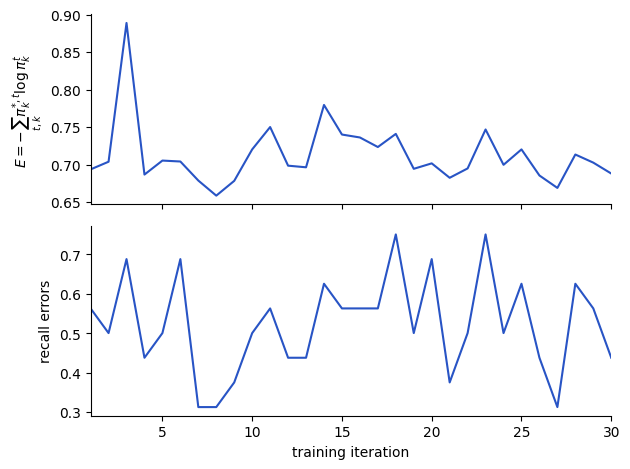

In [25]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(range(1, n_iter + 1), loss)
axs[0].set_ylabel(r"$E = -\sum_{t,k} \pi_k^{*,t} \log \pi_k^t$")

axs[1].plot(range(1, n_iter + 1), recall_errors)
axs[1].set_ylabel("recall errors")

axs[-1].set_xlabel("training iteration")
axs[-1].set_xlim(1, n_iter)
axs[-1].xaxis.get_major_locator().set_params(integer=True)

fig.tight_layout()

### Plot spikes and dynamic variables
This plotting routine shows how to plot all of the recorded dynamic variables and spikes across time. We take
one snapshot in the first iteration and one snapshot at the end.



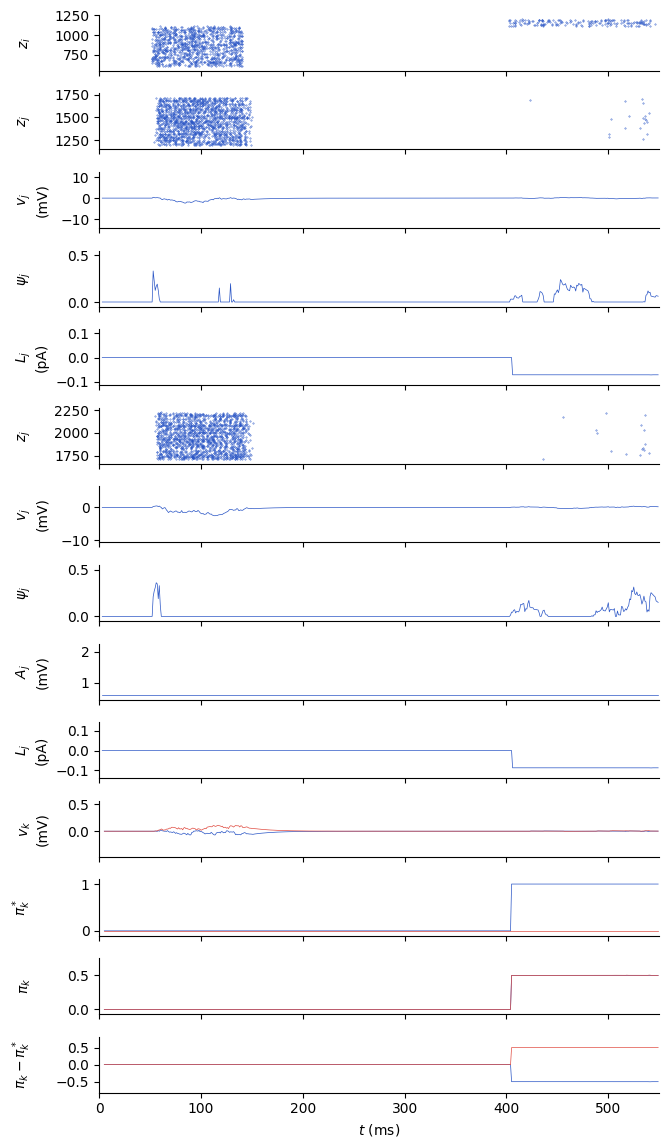

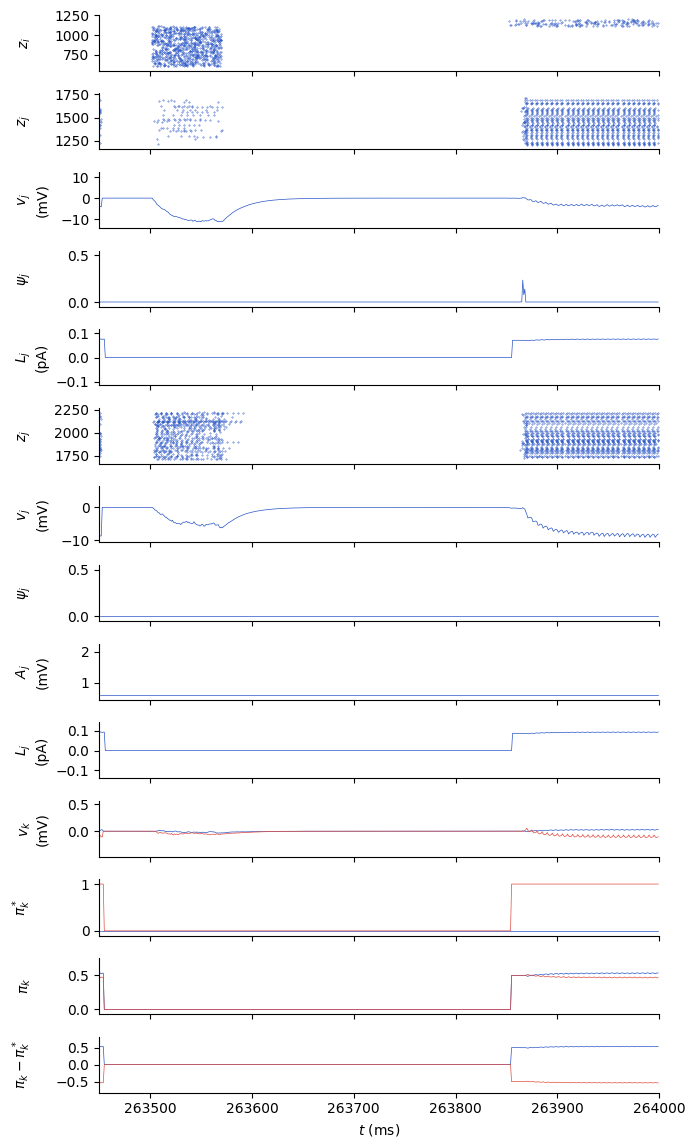

In [26]:
def plot_recordable(ax, events, recordable, ylabel, xlims):
    for sender in set(events["senders"]):
        idc_sender = events["senders"] == sender
        idc_times = (events["times"][idc_sender] > xlims[0]) & (events["times"][idc_sender] < xlims[1])
        ax.plot(events["times"][idc_sender][idc_times], events[recordable][idc_sender][idc_times], lw=0.5)
    ax.set_ylabel(ylabel)
    margin = np.abs(np.max(events[recordable]) - np.min(events[recordable])) * 0.1
    ax.set_ylim(np.min(events[recordable]) - margin, np.max(events[recordable]) + margin)


def plot_spikes(ax, events, nrns, ylabel, xlims):
    idc_times = (events["times"] > xlims[0]) & (events["times"] < xlims[1])
    idc_sender = np.isin(events["senders"][idc_times], nrns.tolist())
    senders_subset = events["senders"][idc_times][idc_sender]
    times_subset = events["times"][idc_times][idc_sender]

    ax.scatter(times_subset, senders_subset, s=0.1)
    ax.set_ylabel(ylabel)
    margin = np.abs(np.max(senders_subset) - np.min(senders_subset)) * 0.1
    ax.set_ylim(np.min(senders_subset) - margin, np.max(senders_subset) + margin)


for xlims in [(0, steps["sequence"]), (steps["task"] - steps["sequence"], steps["task"])]:
    fig, axs = plt.subplots(14, 1, sharex=True, figsize=(8, 14), gridspec_kw={"hspace": 0.4, "left": 0.2})

    plot_spikes(axs[0], events_sr, nrns_in, r"$z_i$" + "\n", xlims)
    plot_spikes(axs[1], events_sr, nrns_reg, r"$z_j$" + "\n", xlims)

    plot_recordable(axs[2], events_mm_reg, "V_m", r"$v_j$" + "\n(mV)", xlims)
    plot_recordable(axs[3], events_mm_reg, "surrogate_gradient", r"$\psi_j$" + "\n", xlims)
    plot_recordable(axs[4], events_mm_reg, "learning_signal", r"$L_j$" + "\n(pA)", xlims)

    plot_spikes(axs[5], events_sr, nrns_ad, r"$z_j$" + "\n", xlims)

    plot_recordable(axs[6], events_mm_ad, "V_m", r"$v_j$" + "\n(mV)", xlims)
    plot_recordable(axs[7], events_mm_ad, "surrogate_gradient", r"$\psi_j$" + "\n", xlims)
    plot_recordable(axs[8], events_mm_ad, "V_th_adapt", r"$A_j$" + "\n(mV)", xlims)
    plot_recordable(axs[9], events_mm_ad, "learning_signal", r"$L_j$" + "\n(pA)", xlims)

    plot_recordable(axs[10], events_mm_out, "V_m", r"$v_k$" + "\n(mV)", xlims)
    plot_recordable(axs[11], events_mm_out, "target_signal", r"$\pi^*_k$" + "\n", xlims)
    plot_recordable(axs[12], events_mm_out, "readout_signal", r"$\pi_k$" + "\n", xlims)
    plot_recordable(axs[13], events_mm_out, "error_signal", r"$\pi_k-\pi^*_k$" + "\n", xlims)

    axs[-1].set_xlabel(r"$t$ (ms)")
    axs[-1].set_xlim(*xlims)

    fig.align_ylabels()

### Plot weight time courses
Similarly, we can plot the weight histories. Note that the weight recorder, attached to the synapses, works
differently than the other recorders. Since synapses only get activated when they transmit a spike, the weight
recorder only records the weight in those moments. That is why the first weight registrations do not start in
the first time step and we add the initial weights manually.



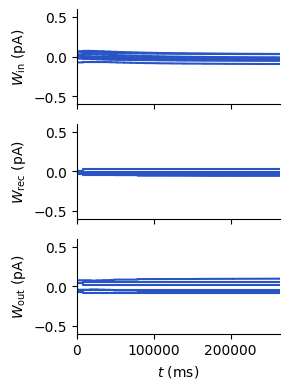

In [27]:
def plot_weight_time_course(ax, events, nrns_senders, nrns_targets, label, ylabel):
    for sender in nrns_senders.tolist():
        for target in nrns_targets.tolist():
            idc_syn = (events["senders"] == sender) & (events["targets"] == target)
            idc_syn_pre = (weights_pre_train[label]["source"] == sender) & (
                weights_pre_train[label]["target"] == target
            )

            times = [0.0] + events["times"][idc_syn].tolist()
            weights = [weights_pre_train[label]["weight"][idc_syn_pre]] + events["weights"][idc_syn].tolist()

            ax.step(times, weights, c=colors["blue"])
        ax.set_ylabel(ylabel)
        ax.set_ylim(-0.6, 0.6)


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3, 4))

plot_weight_time_course(axs[0], events_wr, nrns_in[:n_record_w], nrns_rec[:n_record_w], "in_rec", r"$W_\text{in}$ (pA)")
plot_weight_time_course(
    axs[1], events_wr, nrns_rec[:n_record_w], nrns_rec[:n_record_w], "rec_rec", r"$W_\text{rec}$ (pA)"
)
plot_weight_time_course(axs[2], events_wr, nrns_rec[:n_record_w], nrns_out, "rec_out", r"$W_\text{out}$ (pA)")

axs[-1].set_xlabel(r"$t$ (ms)")
axs[-1].set_xlim(0, steps["task"])

fig.align_ylabels()
fig.tight_layout()

### Plot weight matrices
If one is not interested in the time course of the weights, it is possible to read out only the initial and
final weights, which requires less computing time and memory than the weight recorder approach. Here, we plot
the corresponding weight matrices before and after the optimization.



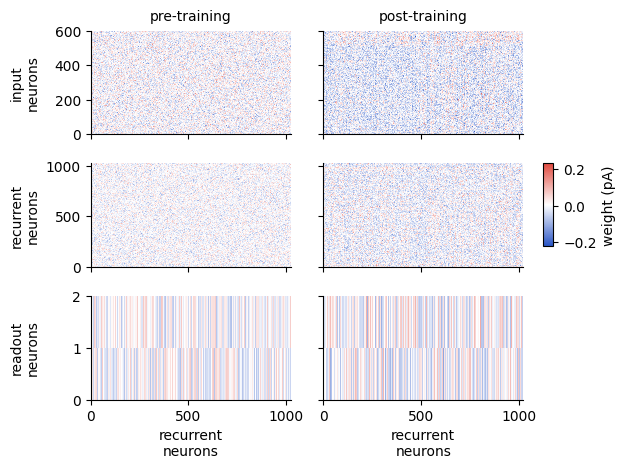

In [28]:
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "cmap", ((0.0, colors["blue"]), (0.5, colors["white"]), (1.0, colors["red"]))
)

fig, axs = plt.subplots(3, 2, sharex="col", sharey="row")

all_w_extrema = []

for k in weights_pre_train.keys():
    w_pre = weights_pre_train[k]["weight"]
    w_post = weights_post_train[k]["weight"]
    all_w_extrema.append([np.min(w_pre), np.max(w_pre), np.min(w_post), np.max(w_post)])

args = {"cmap": cmap, "vmin": np.min(all_w_extrema), "vmax": np.max(all_w_extrema)}

for i, weights in zip([0, 1], [weights_pre_train, weights_post_train]):
    axs[0, i].pcolormesh(weights["in_rec"]["weight_matrix"].T, **args)
    axs[1, i].pcolormesh(weights["rec_rec"]["weight_matrix"], **args)
    cmesh = axs[2, i].pcolormesh(weights["rec_out"]["weight_matrix"], **args)

    axs[2, i].set_xlabel("recurrent\nneurons")

axs[0, 0].set_ylabel("input\nneurons")
axs[1, 0].set_ylabel("recurrent\nneurons")
axs[2, 0].set_ylabel("readout\nneurons")
fig.align_ylabels(axs[:, 0])

axs[0, 0].text(0.5, 1.1, "pre-training", transform=axs[0, 0].transAxes, ha="center")
axs[0, 1].text(0.5, 1.1, "post-training", transform=axs[0, 1].transAxes, ha="center")

axs[2, 0].yaxis.get_major_locator().set_params(integer=True)

cbar = plt.colorbar(cmesh, cax=axs[1, 1].inset_axes([1.1, 0.2, 0.05, 0.8]), label="weight (pA)")

fig.tight_layout()

plt.show()